# Parkinson's Disease Classification using CNN

This notebook implements a convolutional neural network (CNN) to classify MRI images into two categories: Non-PD Patients and PD Patients. The goal is to predict whether an MRI scan indicates Parkinson's Disease (PD).

### Pipeline Overview

1) Data Preparation:

 - MRI images are preprocessed by resizing to (64x64) and normalizing pixel values.
 - Labels are assigned based on folder structure (0 for Non-PD, 1 for PD).
 - Data is split into training (80%) and validation (20%) sets.

2) Model Architecture:

 - A CNN with three convolutional layers, Batch Normalization, Dropout, and Fully Connected layers.
 - The output layer uses a Sigmoid activation for binary classification.

3) Training:

 - Binary Cross-Entropy Loss (BCELoss) is used with the Adam optimizer.
 - Training and validation loss/accuracy are recorded at each epoch.

4) Dataset:

- Images are loaded from the ntua-parkinson-dataset-master directory, structured into two categories: Non PD Patients and PD Patients.

In [1]:
! pip install -q kaggle
!kaggle datasets download -d shayalvaghasiya/ntua-prakinson
!unzip ntua-prakinson.zip

Streaming output truncated to the last 5000 lines.
  inflating: ntua-parkinson-dataset-master/PD Patients/Subject68/1.MRI/_MPR_Thick_Range2__022.png  
  inflating: ntua-parkinson-dataset-master/PD Patients/Subject68/1.MRI/_MPR_Thick_Range2__023.png  
  inflating: ntua-parkinson-dataset-master/PD Patients/Subject68/1.MRI/_MPR_Thick_Range2__024.png  
  inflating: ntua-parkinson-dataset-master/PD Patients/Subject68/1.MRI/_MPR_Thick_Range2__025.png  
  inflating: ntua-parkinson-dataset-master/PD Patients/Subject68/1.MRI/_MPR_Thick_Range__001.png  
  inflating: ntua-parkinson-dataset-master/PD Patients/Subject68/1.MRI/_MPR_Thick_Range__002.png  
  inflating: ntua-parkinson-dataset-master/PD Patients/Subject68/1.MRI/_MPR_Thick_Range__003.png  
  inflating: ntua-parkinson-dataset-master/PD Patients/Subject68/1.MRI/_MPR_Thick_Range__004.png  
  inflating: ntua-parkinson-dataset-master/PD Patients/Subject68/1.MRI/_MPR_Thick_Range__005.png  
  inflating: ntua-parkinson-dataset-master/PD Patients

In [2]:
import random
import numpy as np
import torch

# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If you're using GPUs

# Ensure deterministic behavior in PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import cv2
import os
import pandas as pd
from tqdm import tqdm

# Updated CNN model with an additional fully connected layer
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 6 * 6, 256)  # Increased size for the first fully connected layer
        self.fc2 = nn.Linear(256, 128)          # New fully connected layer
        self.fc3 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(self.bn1(torch.relu(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool2(self.bn2(torch.relu(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool3(self.bn3(torch.relu(self.conv3(x))))
        x = self.dropout3(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Custom dataset class for loading images
class ParkinsonDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.resize(image, (64, 64))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0  # Normalize to [0, 1]
        image = np.transpose(image, (2, 0, 1))  # Change to (C, H, W)
        label = self.labels[idx]
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

# Prepare the dataset and DataLoader
def get_image_paths_and_labels(base_directory):
    image_paths = []
    labels = []
    patient_types = {'Non PD Patients': 0, 'PD Patients': 1}
    for patient_type, label in patient_types.items():
        patient_folder = os.path.join(base_directory, patient_type)
        for subject in os.listdir(patient_folder):
            subject_path = os.path.join(patient_folder, subject, '1.MRI')
            if os.path.exists(subject_path):
                for image_file in os.listdir(subject_path):
                    if image_file.endswith('.png'):
                        image_paths.append(os.path.join(subject_path, image_file))
                        labels.append(label)
    return image_paths, labels

# Load data and create DataLoader
image_paths, labels = get_image_paths_and_labels('ntua-parkinson-dataset-master')
dataset = ParkinsonDataset(image_paths, labels)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))  # 80% of the data for training
val_size = len(dataset) - train_size  # 20% of the data for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
model = CNNModel()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation
num_epochs = 12
history = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        labels = labels.unsqueeze(1)  # Ensure labels have the correct shape for BCELoss
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = (outputs >= 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            labels = labels.unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = (outputs >= 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val

    # Store results for the epoch
    history.append([epoch + 1, train_loss / len(train_loader), train_accuracy, val_loss / len(val_loader), val_accuracy])

    # Print epoch results in a neat tabular format with both train and val accuracy
    df_history = pd.DataFrame(history, columns=["Epoch", "Training Loss", "Training Accuracy (%)", "Validation Loss", "Validation Accuracy (%)"])
    print(df_history.tail(1).to_string(index=False))

# Display full training history
print("\nFull Training History:")
print(df_history.to_string(index=False))


Epoch 1/12: 100%|██████████| 1078/1078 [04:56<00:00,  3.64it/s]


 Epoch  Training Loss  Training Accuracy (%)  Validation Loss  Validation Accuracy (%)
     1       0.436852              80.936494         0.311014                86.330935


Epoch 2/12: 100%|██████████| 1078/1078 [04:48<00:00,  3.74it/s]


 Epoch  Training Loss  Training Accuracy (%)  Validation Loss  Validation Accuracy (%)
     2       0.278684              88.024022         0.207022                91.134834


Epoch 3/12: 100%|██████████| 1078/1078 [04:44<00:00,  3.79it/s]


 Epoch  Training Loss  Training Accuracy (%)  Validation Loss  Validation Accuracy (%)
     3       0.204351              91.331341         0.182589                92.399629


Epoch 4/12: 100%|██████████| 1078/1078 [04:45<00:00,  3.78it/s]


 Epoch  Training Loss  Training Accuracy (%)  Validation Loss  Validation Accuracy (%)
     4       0.156923              93.405669         0.153047                93.351126


Epoch 5/12: 100%|██████████| 1078/1078 [04:43<00:00,  3.81it/s]


 Epoch  Training Loss  Training Accuracy (%)  Validation Loss  Validation Accuracy (%)
     5       0.130355              94.621254         0.130974                94.302622


Epoch 6/12: 100%|██████████| 1078/1078 [04:42<00:00,  3.81it/s]


 Epoch  Training Loss  Training Accuracy (%)  Validation Loss  Validation Accuracy (%)
     6       0.108804              95.552525          0.12186                95.451381


Epoch 7/12: 100%|██████████| 1078/1078 [04:45<00:00,  3.77it/s]


 Epoch  Training Loss  Training Accuracy (%)  Validation Loss  Validation Accuracy (%)
     7       0.089142              96.402565         0.086839                96.530518


Epoch 8/12: 100%|██████████| 1078/1078 [04:40<00:00,  3.84it/s]


 Epoch  Training Loss  Training Accuracy (%)  Validation Loss  Validation Accuracy (%)
     8       0.075973              97.003104         0.085846                96.646554


Epoch 9/12: 100%|██████████| 1078/1078 [04:40<00:00,  3.84it/s]


 Epoch  Training Loss  Training Accuracy (%)  Validation Loss  Validation Accuracy (%)
     9       0.069486              97.278714         0.084011                96.878626


Epoch 10/12: 100%|██████████| 1078/1078 [04:37<00:00,  3.89it/s]


 Epoch  Training Loss  Training Accuracy (%)  Validation Loss  Validation Accuracy (%)
    10          0.063              97.615248         0.073662                97.226735


Epoch 11/12: 100%|██████████| 1078/1078 [04:43<00:00,  3.80it/s]


 Epoch  Training Loss  Training Accuracy (%)  Validation Loss  Validation Accuracy (%)
    11       0.056581              97.783516         0.067786                 97.56324


Epoch 12/12: 100%|██████████| 1078/1078 [04:59<00:00,  3.60it/s]


 Epoch  Training Loss  Training Accuracy (%)  Validation Loss  Validation Accuracy (%)
    12       0.050268               98.07073         0.070239                97.354375

Full Training History:
 Epoch  Training Loss  Training Accuracy (%)  Validation Loss  Validation Accuracy (%)
     1       0.436852              80.936494         0.311014                86.330935
     2       0.278684              88.024022         0.207022                91.134834
     3       0.204351              91.331341         0.182589                92.399629
     4       0.156923              93.405669         0.153047                93.351126
     5       0.130355              94.621254         0.130974                94.302622
     6       0.108804              95.552525         0.121860                95.451381
     7       0.089142              96.402565         0.086839                96.530518
     8       0.075973              97.003104         0.085846                96.646554
     9       0.0694

## Loss vs Epoch

This plot shows how the training and validation loss change over the epochs. It is used to monitor whether the model is overfitting or underfitting during training.

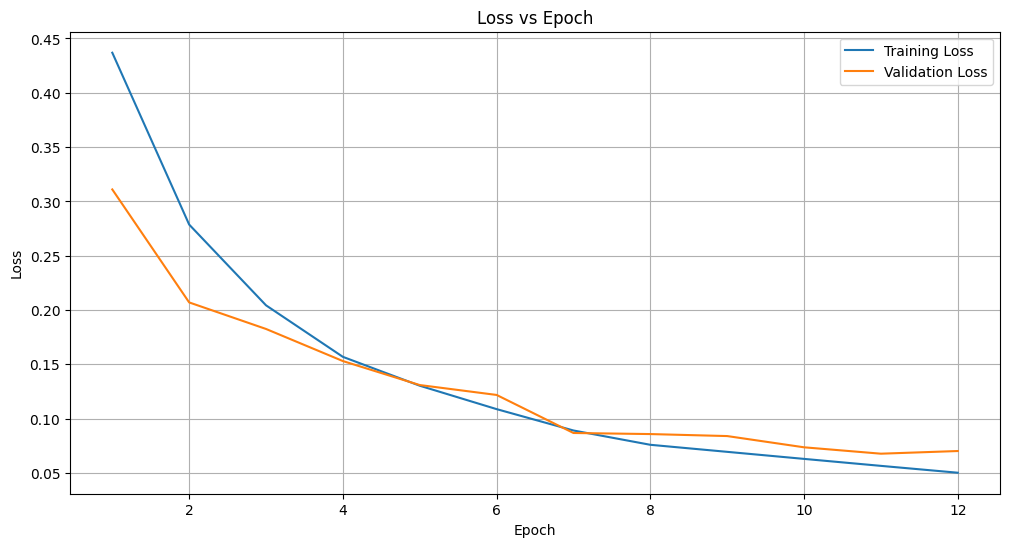

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_history['Epoch'], df_history['Training Loss'], label='Training Loss')
plt.plot(df_history['Epoch'], df_history['Validation Loss'], label='Validation Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Accuracy vs Epoch

This plot shows the training and validation accuracy over epochs. It helps evaluate the performance of the model in terms of classification accuracy.

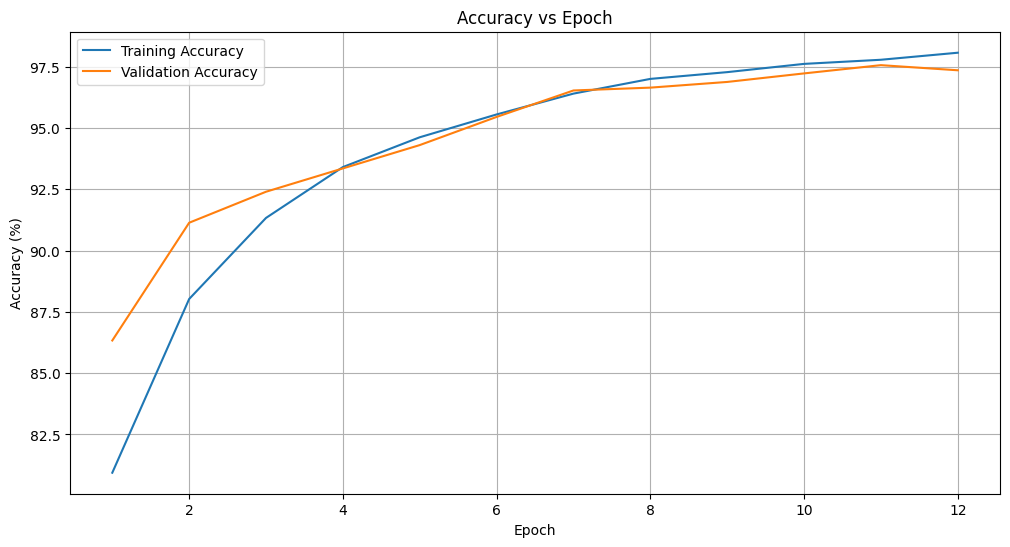

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df_history['Epoch'], df_history['Training Accuracy (%)'], label='Training Accuracy')
plt.plot(df_history['Epoch'], df_history['Validation Accuracy (%)'], label='Validation Accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


##  Confusion Matrix

A confusion matrix provides insights into the performance of a classification model by showing the counts of true positives, true negatives, false positives, and false negatives.

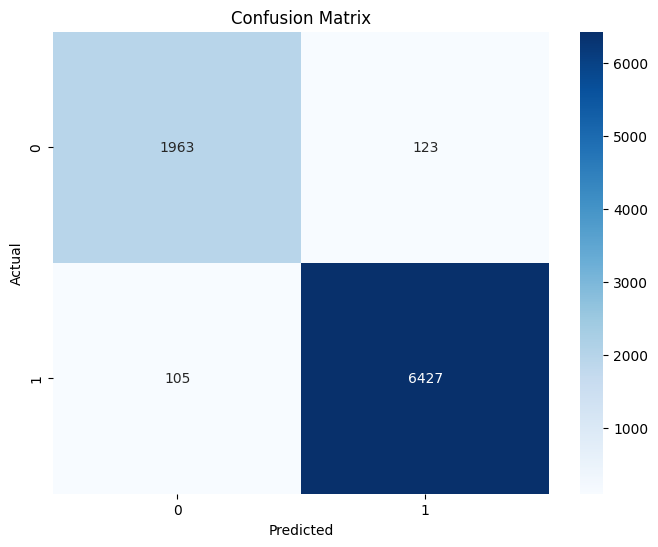

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        preds = (outputs >= 0.5).float().squeeze(1)
        all_labels.extend(labels.numpy())
        all_preds.extend(preds.numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## ROC Curve

The ROC curve plots the true positive rate against the false positive rate at various thresholds. The area under the curve (AUC) measures the model's ability to distinguish between classes.

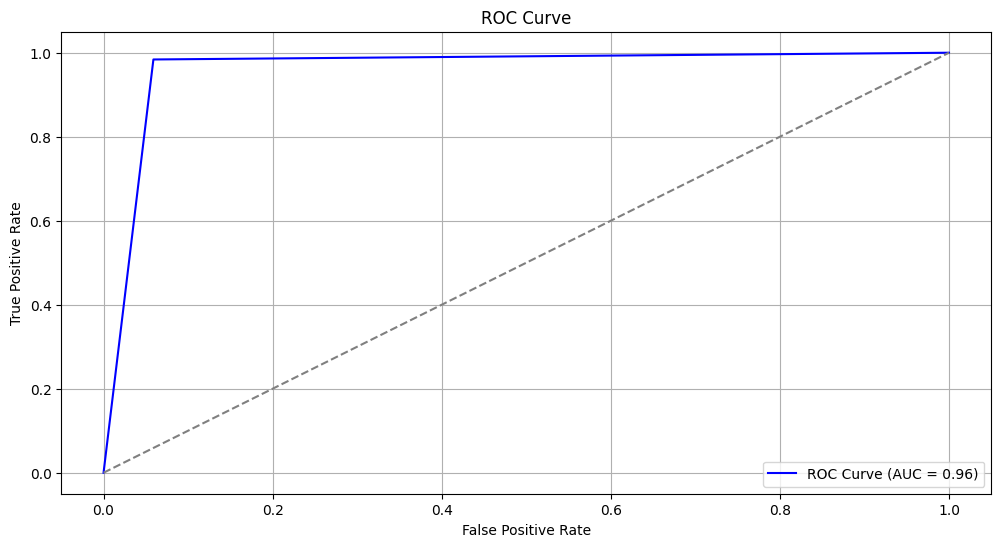

In [7]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


## Precision-Recall Curve

The precision-recall curve shows the trade-off between precision and recall for different thresholds. It is useful for imbalanced datasets.

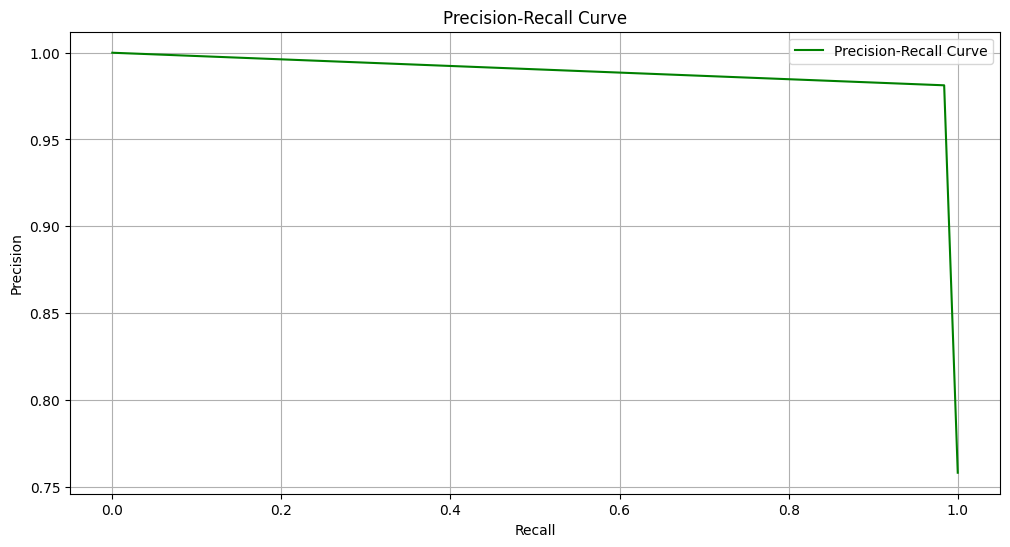

In [8]:
from sklearn.metrics import precision_recall_curve


precision, recall, _ = precision_recall_curve(all_labels, all_preds)
plt.figure(figsize=(12, 6))
plt.plot(recall, precision, color='green', label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()


## Activation Map Visualization

This visualizes the activation maps generated by the first convolutional layer of the model for a sample image. It helps understand which features the model focuses on.

<ipython-input-9-dd3b80e91664>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0)


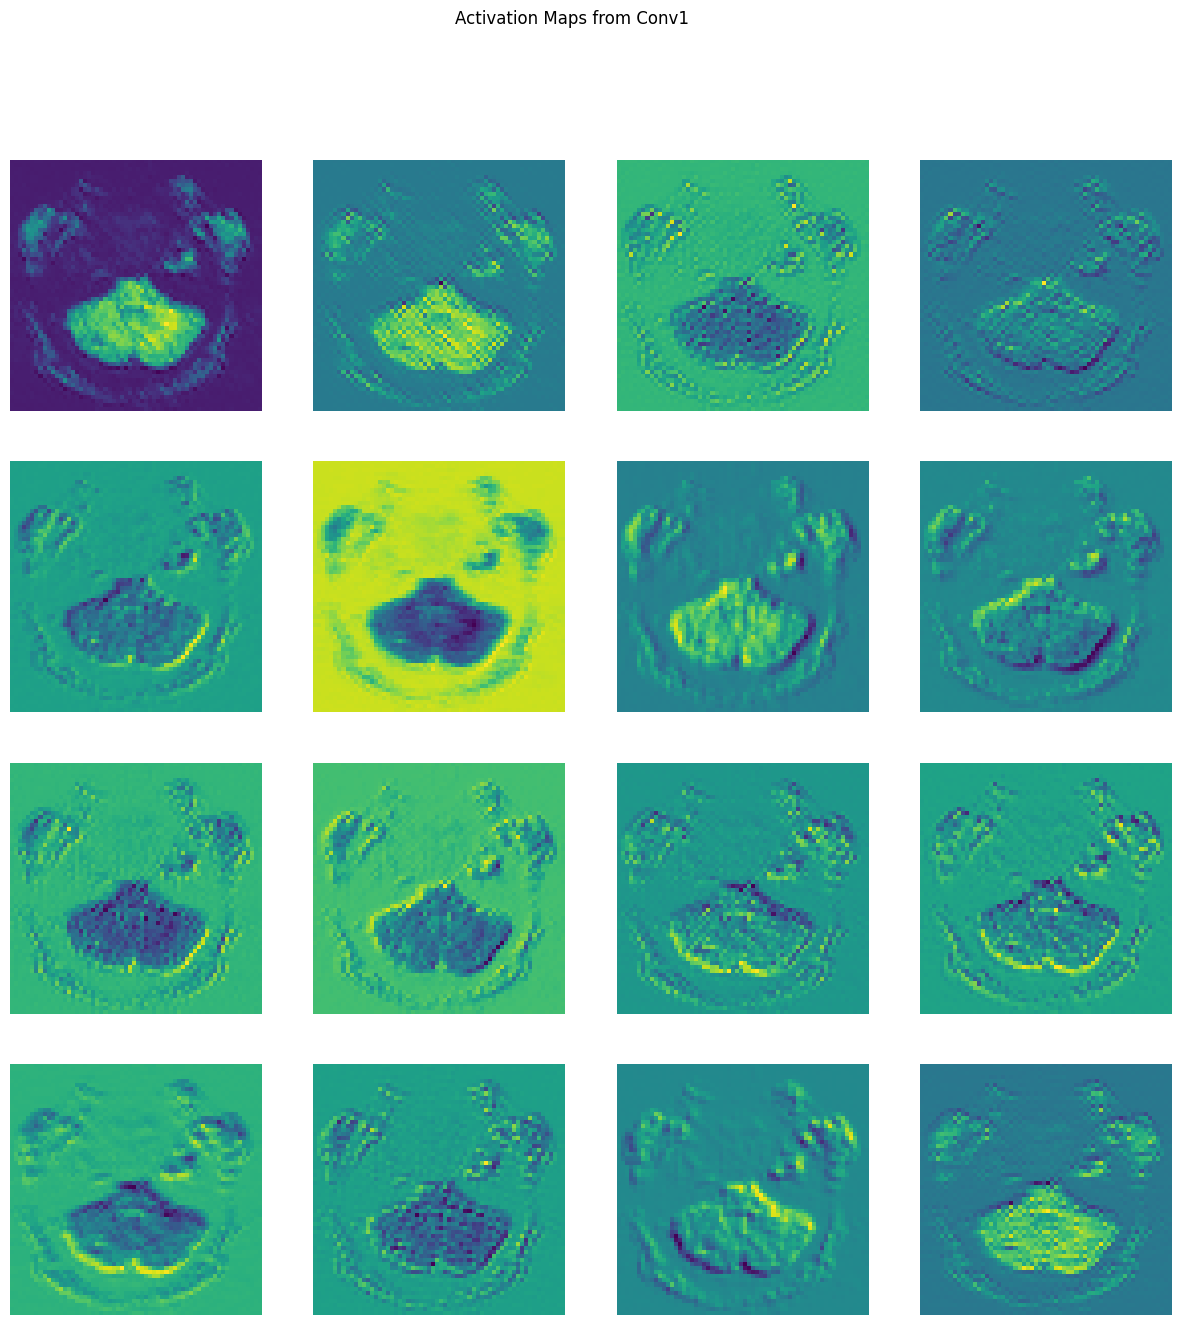

In [9]:
def visualize_activation_maps(model, image):
    model.eval()
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        activations = model.conv1(image_tensor)
    act_map = activations[0].cpu().numpy()
    num_channels = act_map.shape[0]

    plt.figure(figsize=(15, 15))
    for i in range(min(num_channels, 16)):  # Display up to 16 activation maps
        plt.subplot(4, 4, i + 1)
        plt.imshow(act_map[i], cmap='viridis')
        plt.axis('off')
    plt.suptitle('Activation Maps from Conv1')
    plt.show()

# Use an image from the validation set to visualize activation maps
sample_image, _ = val_dataset[0]
visualize_activation_maps(model, sample_image)


## Heatmap of Model Weights

This heatmap visualizes the weights of the first convolutional layer, showing how the layer has learned to identify different features during training.

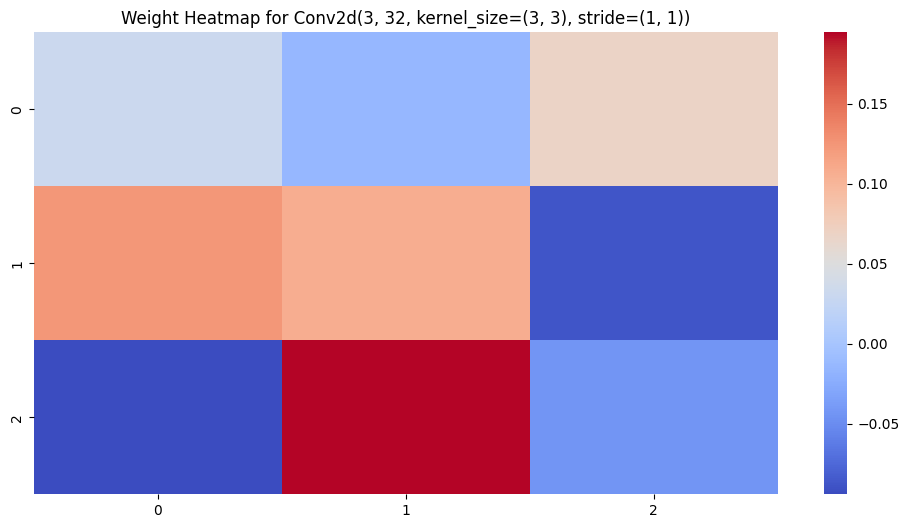

In [10]:
def plot_weight_heatmap(layer):
    weights = layer.weight.data.cpu().numpy()
    plt.figure(figsize=(12, 6))
    sns.heatmap(weights[0, 0, :, :], cmap='coolwarm')
    plt.title(f'Weight Heatmap for {layer}')
    plt.show()

# Display heatmap for the first convolutional layer
plot_weight_heatmap(model.conv1)
